# Detekcija vozačeve nepažnje

Tema ovog rada je detekcija vozačeve nepažnje. Koristi se skup podataka koji se sastoji od slika kategorizovanih u 10 različitih klasa (devet raličitih nepažljivih aktivnosti i jedna aktivnost koja demonstrira sigurnu vožnju).
Skup podataka je dostupan na adresi https://www.kaggle.com/c/state-farm-distracted-driver-detection/data .

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

#potreban je python openCv koji je potrebno instalirati komandom conda install -c menpo opencv
import cv2

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics



In [3]:
import seaborn as sns


In [4]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# 1. Učitavanje podataka

## Opis skupa podataka

In [5]:
# promenljiva df sadrži označene podatke
df = pd.read_csv('../data/driver_imgs_list.csv')
print(df)

      subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
...       ...       ...            ...
22419    p081        c9  img_56936.jpg
22420    p081        c9  img_46218.jpg
22421    p081        c9  img_25946.jpg
22422    p081        c9  img_67850.jpg
22423    p081        c9   img_9684.jpg

[22424 rows x 3 columns]


In [6]:
# mapa aktivnosti 
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

Sledeći kod daje prikaz po jedne od slika iz svake klase

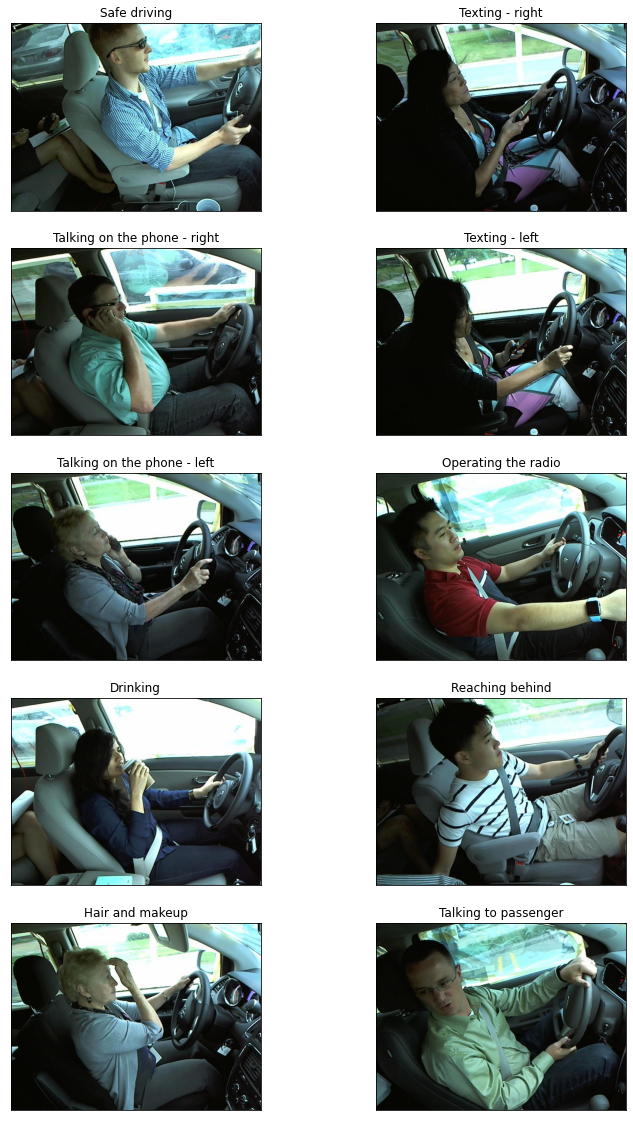

In [7]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../data/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(image)
                plt.title(activity_map[directory])

Na sledećem dijagramu prikazana je distribucija klasa u skupu:

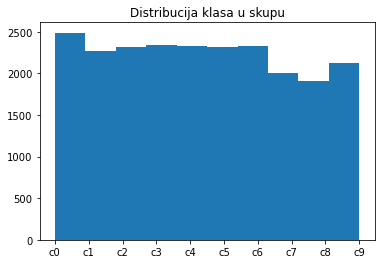

In [8]:
plt.hist(df['classname'])
plt.title('Distribucija klasa u skupu')
plt.show()

Na osnovu dijagrama zaključujemo da je skup balansiran.

## Priprema podataka

Radi lakšeg rada, slike ćemo normalizovati (svesti vrednosti pojedinačnih piksela na vrednost iz intervala iz [0, 1])  i  smanjiti im rezoluciju. 

U nastavku je dat primer slike i njen prikaz u originalnoj i smanjenoj rezoluciji. 

In [9]:
# Primer slike
example_img = cv2.imread("../data/train/c0/img_44733.jpg")
example_img_resized = cv2.resize(cv2.imread('../data/train/c0/img_44733.jpg'), (160, 120), interpolation=cv2.INTER_NEAREST)
print('Originalna dimenzija slike: {}'.format(example_img.shape))
print('Smanjena dimenzija slike: {}'.format(example_img_resized.shape))


Originalna dimenzija slike: (480, 640, 3)
Smanjena dimenzija slike: (120, 160, 3)


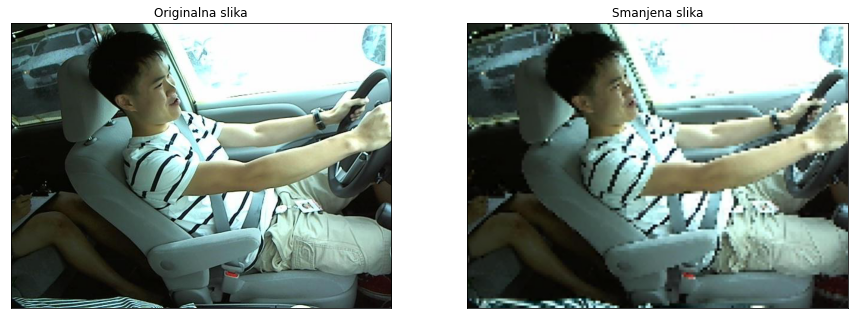

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
ax[0].imshow(example_img[:,:,::-1])
ax[0].title.set_text('Originalna slika')
ax[1].imshow(example_img_resized[:,:,::-1])
ax[1].title.set_text('Smanjena slika')
plt.show()

In [11]:
# Funkcija zadužena za normalizaciju i promenu dimenzije slike
def normalize_and_resize(image):
  image_resized = cv2.resize(image, (160, 120)) #resize the image to 120x160
  image_data = image_resized/255 # Normalize the image
  return image_data

In [12]:
number_of_images = df.shape[0]
X = np.ndarray(shape = (number_of_images, 120, 160, 3), dtype = np.float32)

for index, row in df.iterrows():
  image = cv2.imread('../data/train/'+row['classname']+'/'+row['img'])
  image_array = normalize_and_resize(image)
  X[index,:,:,:] = image_array 

#Kodiramo tip 'classname' u numeričku vrednost
y = pd.factorize(df['classname'])[0]

print('Dimenzija X: {}'.format(X.shape)) 
print('Dimenzija y: {}'.format(y.shape))

Dimenzija X: (22424, 120, 160, 3)
Dimenzija y: (22424,)


## Podela podataka na skup za treniranje i skup za testiranje

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:
# Zbog prevelike količine podataka, oslobađamo memoriju koja se više ne koristi
del X, y

# 2. Pravljenje modela

## Osnovni model

### SVM

In [15]:
# model_svm = svm.SVC(kernel='rbf', C=1000, gamma=0.1)
# model_svm.fit(X_train.reshape(X_train.shape[0], -1), y_train)

Nije bilo moguće napraviti SVM kalsifikacioni model zbog nedostatka RAM memorije. 

### Slučajne šume (Random forest)

Definišemo liste parametara kako bismo pmoću RandomizedSearchCV izabrali njihove optimalne vrednosti.

In [16]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 15, num = 5)] #broj stabala
max_depth = [int(x) for x in np.linspace(start = 3, stop = 9, num = 3)] #maksimalna dubina stabla
max_depth.append(None)
min_samples_split = [2, 4, 6] 
min_samples_leaf = [1, 2, 3]

bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [5, 7, 10, 12, 15], 'max_depth': [3, 6, 9, None], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [17]:

rf = ensemble.RandomForestClassifier()

model_rfCV = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, verbose=1, random_state=123) 

In [18]:
model_rfCV.fit(X_train.reshape(X_train.shape[0], -1), y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 28.2min finished


RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 6, 9, None],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [5, 7, 10, 12, 15]},
                   random_state=123, verbose=1)

In [91]:
#optimalni parametri
print(model_rfCV.best_params_)

{'n_estimators': 15, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


In [20]:
y_predict_rf = model_rfCV.predict(X_test.reshape(X_test.shape[0], -1))

In [21]:
confusion_matrix_rf = metrics.confusion_matrix(y_test, y_predict_rf, normalize='true')

Definišemo funkciju koja radi prikaz matrice konfuzije:

In [22]:
def plot_confusion_matrix(conf):    
    fig, ax = plt.subplots(figsize=(13, 13))
    plt.title('Matrica konfuzije')
    sns.heatmap(conf, annot=True, fmt='.5f', cmap=plt.cm.Blues, ax=ax)
    plt.xlabel('Predviđene vrednosti')
    plt.ylabel('Stvarne vrednosti')
    plt.show()

U nastavku je prikazana matrica konfuzije modela.

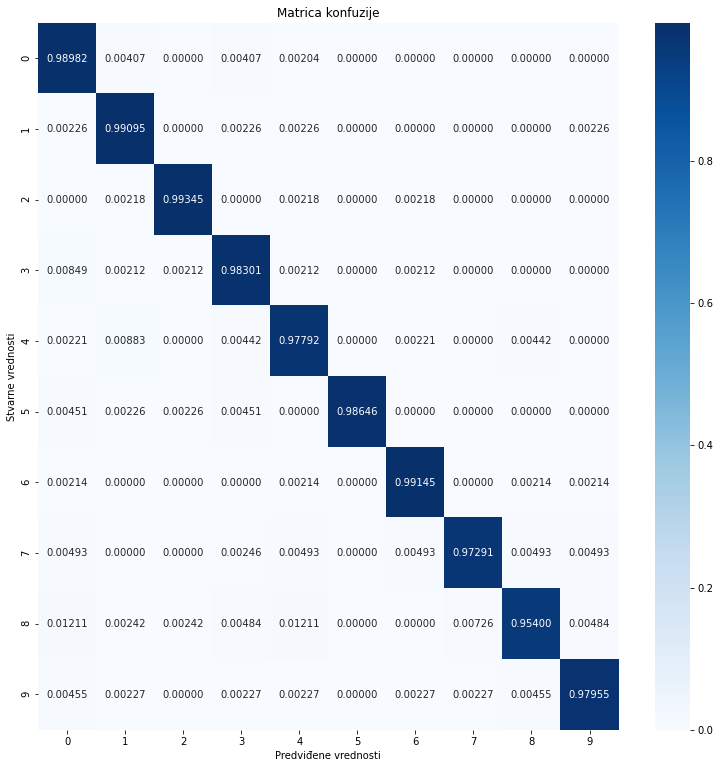

In [23]:
plot_confusion_matrix(confusion_matrix_rf)

In [78]:
#Tačnost i r2_score
accuracy_rf = metrics.accuracy_score(y_test, y_predict_rf)
precision_rf = metrics.precision_score(y_test, y_predict_rf, average='macro')
recall_rf = metrics.recall_score(y_test, y_predict_rf, average='macro')
f1_score_rf = metrics.f1_score(y_test, y_predict_rf, average='macro')
print('Tačnost modela je: {}'.format(accuracy_rf))
print('Preciznost modela je: {}'.format(precision_rf))
print('Odziv modela je: {}'.format(recall_rf))
print('F1 mera je: {}'.format(f1_score_rf))

Tačnost modela je: 0.9823857302118172
Preciznost modela je: 0.9827543730223771
Odziv modela je: 0.9819512504588477
F1 mera je: 0.9822933338806136


In [25]:
report_rf = metrics.classification_report(y_test, y_predict_rf)

In [26]:
print(report_rf)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       491
           1       0.98      0.99      0.98       442
           2       0.99      0.99      0.99       458
           3       0.98      0.98      0.98       471
           4       0.97      0.98      0.97       453
           5       1.00      0.99      0.99       443
           6       0.99      0.99      0.99       468
           7       0.99      0.97      0.98       406
           8       0.98      0.95      0.97       413
           9       0.99      0.98      0.98       440

    accuracy                           0.98      4485
   macro avg       0.98      0.98      0.98      4485
weighted avg       0.98      0.98      0.98      4485



Na osnovu dobijenih rezultata možemo zaključiti da je model prilično dobar. Ipak, pokušaćemo malo da poboljšamo rezultat korišćenjem neuronskih mreža.

## Konvolutivna neuronska mreža

### CNN model

In [27]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 160, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(10))

In [28]:
print('Prikaz modela i uvid u broj parametara koje mreža treba da nauči: \n')
model_cnn.summary()

Prikaz modela i uvid u broj parametara koje mreža treba da nauči: 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 38, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 68096)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4358208   
______________________________________________________

#### Treniranje mreže

Funkcija gubitka koju mreža minimizuje će biti `kategorička unakrsna entropija`. Za treniranje mreže ćemo koristiti optimizator `Adam`, a za metriku biće uzeta tačnost pošto rešavamo klasifikacioni zadatak.

In [29]:
#default learning_rate za adam optimizator je 0.001
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Mrežu ćemo trenirati koristeći paketiće veličine 32 u 20 epoha.

In [30]:
batch_size = 32
epochs = 20

In [31]:
history = model_cnn.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
505/505 [==============================] - 285s 563ms/step - loss: 0.5434 - accuracy: 0.8219 - val_loss: 0.0738 - val_accuracy: 0.9788
Epoch 2/20
505/505 [==============================] - 286s 566ms/step - loss: 0.0491 - accuracy: 0.9855 - val_loss: 0.0389 - val_accuracy: 0.9889
Epoch 3/20
505/505 [==============================] - 309s 612ms/step - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0711 - val_accuracy: 0.9816
Epoch 4/20
505/505 [==============================] - 302s 599ms/step - loss: 0.0179 - accuracy: 0.9945 - val_loss: 0.0246 - val_accuracy: 0.9933
Epoch 5/20
505/505 [==============================] - 276s 546ms/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0419 - val_accuracy: 0.9894
Epoch 6/20
505/505 [==============================] - 271s 537ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0342 - val_accuracy: 0.9889
Epoch 7/20
505/505 [==============================] - 280s 554ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0426 -

Definisaćemo funkciju koja iscrtava grafike funkcije gubitka i tačnosti u toku treniranja

In [39]:
def plot_loss_and_accuracy(history):
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1,2,1)
    plt.title('Model loss')   
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Model accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')

    plt.show()

Grafici funkcije gubitka i tačnosti u toku treniranja:

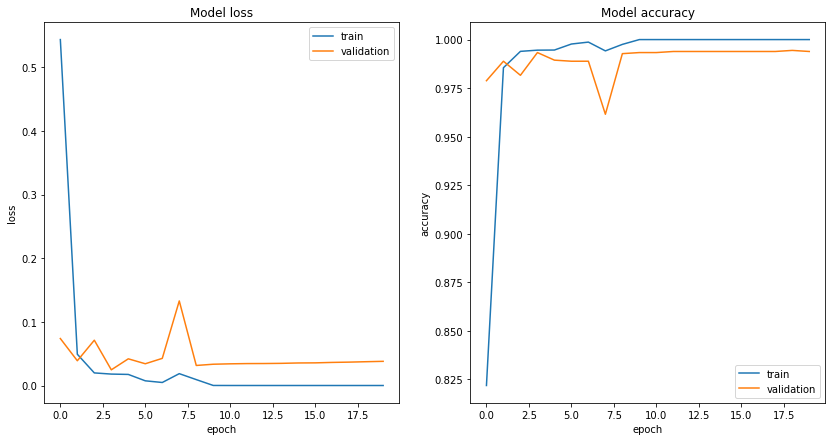

In [40]:
plot_loss_and_accuracy(history)

Na grafiku se vidi da gubitak na validacionom skupu blago raste posle devete epohe, a da tačnost više ne menja vrednost. Na osnovu toga možemo zaključiti da nam je 9 epoha dovoljno za treniranje mreže. 

Takođe, vidi se da mreža blago overfituje, što ćemo pokušati da popravimo dodavanjem Dropout sloja.
Malo ćemo izmeniti model:

In [58]:
tf.random.set_seed(0)

In [59]:
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 160, 3)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Dropout(0.1))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(64, activation='relu'))
model_cnn2.add(Dropout(0.1))
model_cnn2.add(Dense(10))

In [60]:
print('Prikaz modela i uvid u broj parametara koje mreža treba da nauči: \n')
model_cnn2.summary()

Prikaz modela i uvid u broj parametara koje mreža treba da nauči: 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 118, 158, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 57, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 38, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 38, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 68096)             0         
____________________________________________________

In [61]:
#treniramo mrežu na isti način kao ranije
model_cnn2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
batch_size = 32
epochs = 9
history2 = model_cnn2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/9
505/505 [==============================] - 331s 654ms/step - loss: 0.6475 - accuracy: 0.7926 - val_loss: 0.0879 - val_accuracy: 0.9766
Epoch 2/9
505/505 [==============================] - 279s 552ms/step - loss: 0.0789 - accuracy: 0.9750 - val_loss: 0.0472 - val_accuracy: 0.9889
Epoch 3/9
505/505 [==============================] - 295s 584ms/step - loss: 0.0418 - accuracy: 0.9871 - val_loss: 0.0320 - val_accuracy: 0.9905
Epoch 4/9
505/505 [==============================] - 328s 649ms/step - loss: 0.0370 - accuracy: 0.9879 - val_loss: 0.0738 - val_accuracy: 0.9788
Epoch 5/9
505/505 [==============================] - 309s 612ms/step - loss: 0.0350 - accuracy: 0.9893 - val_loss: 0.0286 - val_accuracy: 0.9922
Epoch 6/9
505/505 [==============================] - 278s 550ms/step - loss: 0.0312 - accuracy: 0.9898 - val_loss: 0.0282 - val_accuracy: 0.9939
Epoch 7/9
505/505 [==============================] - 285s 564ms/step - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0432 - val_ac

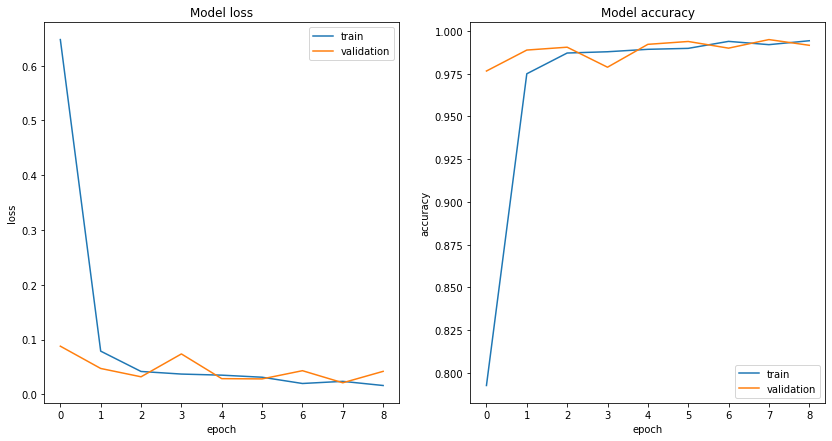

In [63]:
plot_loss_and_accuracy(history2)

Kreiramo sada finalni model:

In [64]:
model_cnn_final = Sequential()
model_cnn_final.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 160, 3)))
model_cnn_final.add(MaxPooling2D((2, 2)))
model_cnn_final.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_final.add(MaxPooling2D((2, 2)))
model_cnn_final.add(Dropout(0.1))

model_cnn_final.add(Flatten())
model_cnn_final.add(Dense(64, activation='relu'))
model_cnn_final.add(Dropout(0.1))
model_cnn_final.add(Dense(10))

In [65]:
print('Prikaz modela i uvid u broj parametara koje mreža treba da nauči: \n')
model_cnn_final.summary()

Prikaz modela i uvid u broj parametara koje mreža treba da nauči: 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 118, 158, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 57, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 38, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 28, 38, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 68096)             0         
____________________________________________________

In [66]:
#treniramo mrežu na isti način kao ranije
model_cnn_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
batch_size = 32
epochs = 9

In [68]:
history = model_cnn_final.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/9
561/561 [==============================] - 395s 703ms/step - loss: 0.5088 - accuracy: 0.8346
Epoch 2/9
561/561 [==============================] - 380s 677ms/step - loss: 0.0621 - accuracy: 0.9810
Epoch 3/9
561/561 [==============================] - 316s 562ms/step - loss: 0.0363 - accuracy: 0.9885
Epoch 4/9
561/561 [==============================] - 305s 544ms/step - loss: 0.0280 - accuracy: 0.9918
Epoch 5/9
561/561 [==============================] - 302s 537ms/step - loss: 0.0238 - accuracy: 0.9927
Epoch 6/9
561/561 [==============================] - 292s 520ms/step - loss: 0.0216 - accuracy: 0.9926
Epoch 7/9
561/561 [==============================] - 299s 533ms/step - loss: 0.0173 - accuracy: 0.9948
Epoch 8/9
561/561 [==============================] - 312s 555ms/step - loss: 0.0143 - accuracy: 0.9947
Epoch 9/9
561/561 [==============================] - 332s 592ms/step - loss: 0.0229 - accuracy: 0.9930


#### Analiza i evaluacija modela

In [69]:
y_predict_cnn = model_cnn_final.predict(X_test)

In [70]:
y_test.shape

(4485,)

In [71]:
y_predict_classes = np.argmax(y_predict_cnn, axis=1)
y_predict_classes.shape

(4485,)

In [72]:
confusion_matrix_cnn = metrics.confusion_matrix(y_test, y_predict_classes, normalize='true')

U nastavku je prikazana matrica konfuzije

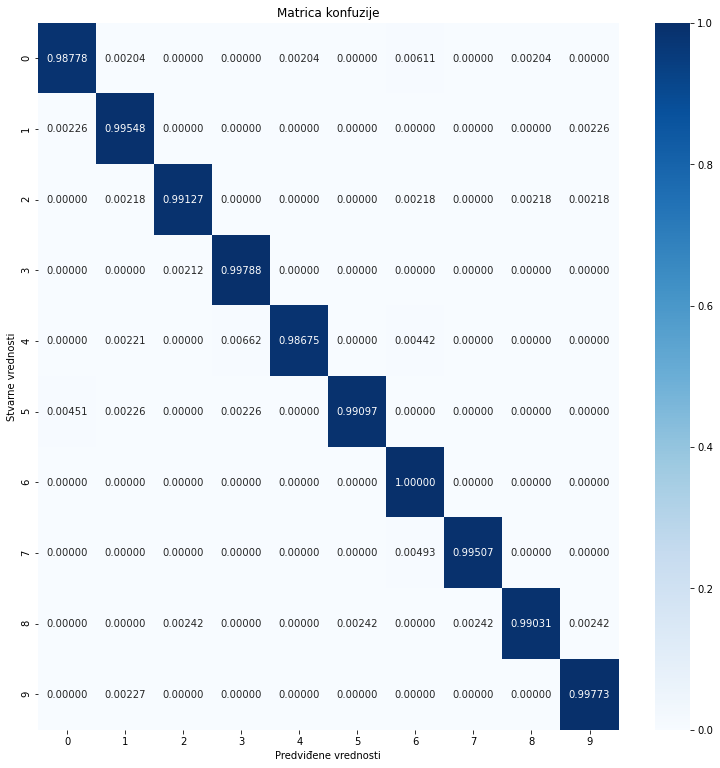

In [73]:
plot_confusion_matrix(confusion_matrix_cnn)

In [79]:
accuracy_cnn = metrics.accuracy_score(y_test, y_predict_classes)
precision_cnn = metrics.precision_score(y_test, y_predict_classes, average='macro')
recall_cnn = metrics.recall_score(y_test, y_predict_classes, average='macro')
f1_score_cnn = metrics.f1_score(y_test, y_predict_classes, average='macro')
print('Tačnost modela je: {}'.format(accuracy_cnn))
print('Preciznost modela je: {}'.format(precision_cnn))
print('Odziv modela je: {}'.format(recall_cnn))
print('F1 mera je: {}'.format(f1_score_cnn))

Tačnost modela je: 0.9933110367892977
Preciznost modela je: 0.9934357481495713
Odziv modela je: 0.9933239942994323
F1 mera je: 0.9933637545658633


In [75]:
report_cnn = metrics.classification_report(y_test, y_predict_classes)

In [76]:
print(report_cnn)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       491
           1       0.99      1.00      0.99       442
           2       1.00      0.99      0.99       458
           3       0.99      1.00      0.99       471
           4       1.00      0.99      0.99       453
           5       1.00      0.99      0.99       443
           6       0.98      1.00      0.99       468
           7       1.00      1.00      1.00       406
           8       1.00      0.99      0.99       413
           9       0.99      1.00      1.00       440

    accuracy                           0.99      4485
   macro avg       0.99      0.99      0.99      4485
weighted avg       0.99      0.99      0.99      4485



## Poređenje osnovnog modela i modela neuronskih mreža

U nastavku je prikazan grafik sa stubićima na kome su upoređene performanse pomenutih modela po klasama. 

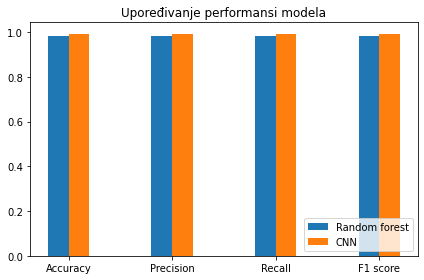

In [87]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 score']
x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [accuracy_rf, precision_rf, recall_rf, f1_score_rf], width, label='Random forest')
rects2 = ax.bar(x + width/2, [accuracy_cnn, precision_cnn, recall_cnn, f1_score_cnn], width, label='CNN')

ax.set_title('Upoređivanje performansi modela')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

fig.tight_layout()

plt.show()

Na osnovu grafika možemo zaključiti da bolje performanse ima CNN model.

CNN model ćemo sačuvati.

In [276]:
model_cnn_path = 'distracted_driver_classifier.h5'
model_cnn_final.save(model_path)

Sačuvani model može se naći na adresi https://drive.google.com/file/d/1aNO0oBRs4GmXRXJsAg2LC7kZPDdMm2oL/view?usp=sharing .

U nastavku je prikazan primer pogrešnih predviđanja, jedna fotografija iz skupa lažno pozitivnih i jedna iz lažno negativnih.

In [117]:
#Indeksi lazno pozitivnih tj. indeksi fotografija koji predviđaju bezbednu vožnju, a zapravo je obrnuto
fpIndices = np.where(np.logical_and(y_predict_classes == 0, y_test!=0))
#Indeksi lazno negativnih tj. indeksi fotografija koji predviđaju nebezbednu vožnju, a zapravo je obrnuto
fnIndices = np.where(np.logical_and(y_test == 0, y_predict_classes!=0))


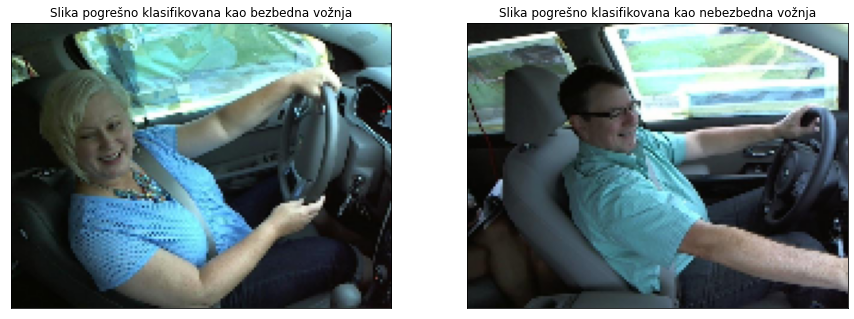

In [116]:
#Posto je dat niz indexa, briamo bilo koji index
fpImage = X_train[fpIndices[0][1]]
fnImage = X_train[fnIndices[0][1]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
ax[0].imshow(fpImage[:,:,::-1])
ax[0].title.set_text('Slika pogrešno klasifikovana kao bezbedna vožnja')
ax[1].imshow(fnImage[:,:,::-1])
ax[1].title.set_text('Slika pogrešno klasifikovana kao nebezbedna vožnja')
plt.show()